## Notebook 2: Adding Building ID to Complaints, Historic Complaints, and 311 Data

The city data provide address and coordinates, which do not always match a specific building in the Master_Address.csv file. I am interested in building, and not address (a building can have multiple addresses, as in appartment building), so I need to tie the snow/ice events to specific buildings.

This notebook explores the code to tie snow/ice events with building ID using address and location data, as available. 

The snow/ice events come from 3 datasets:

    Snow_Ice_Sidewalk_Ordinance_Violations.csv
    Unshoveled_Icy_Sidewalk_Complaints.csv
    Commonwealth_Connect_Service_Requests.csv 

In [2]:
# Starting with Commonwealth_Connect_Service_Requests.csv
import pandas as pd
import numpy as np

tickets = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/external/Snow_Ice_Sidewalk_Ordinance_Violations.csv')

tickets

,TICKET NUMBER,TICKET TYPE,OFFENSE DATE,ISSUANCE DATE,TIME OF DAY,TICKET LOCATION
0,17189,Snow & Ice,02/25/2011,02/28/2011,8:27,"96 FOSTER ST\nCambridge, MA\n(42.376162139, -7..."
1,16819,Snow & Ice,02/07/2011,02/08/2011,12:08,"94-98 PLEASANT ST\nCambridge, MA\n(42.36185930..."
2,17396,Snow & Ice,02/14/2013,02/15/2013,11:42,"406 NORFOLK ST\nCambridge, MA\n(42.374172573, ..."
3,9669,Snow & Ice,02/26/2008,02/26/2008,12:00,"38 SACRAMENTO ST\nCambridge, MA\n(42.382551595..."
4,1001,Snow & Ice,12/29/2010,12/29/2010,12:45,"235 THIRD ST\nCambridge, MA\n(42.367117597, -7..."
...,...,...,...,...,...,...
6540,21222,Snow & Ice,01/24/2019,04/17/2019,1899-12-31T12:10:00.000,"6 STANDISH ST\nCambridge, MA\n(42.381472, -71...."
6541,21229,Snow & Ice,02/14/2019,04/17/2019,1899-12-31T10:43:00.000,"12 TUFTS ST\nCambridge, MA\n(42.357266, -71.11..."
6542,21371,Snow & Ice,03/07/2019,04/17/2019,1899-12-31T11:38:00.000,"156 THORNDIKE ST\nCambridge, MA\n(42.370299, -..."
6543,21239,Snow & Ice,02/14/2019,04/17/2019,1899-12-31T10:48:00.000,"338 HARVARD ST\nCambridge, MA\n(42.370593, -71..."


In [3]:
tickets['OFFENSE DATE'] = pd.to_datetime(tickets['OFFENSE DATE'],infer_datetime_format=True)
tickets['OFFENSE DATE'] = tickets['OFFENSE DATE'].dt.date

print('ticket dates:',min(tickets['OFFENSE DATE']),'to',max(tickets['OFFENSE DATE']))

ticket dates: 2007-12-04 to 2019-03-07


=> there are 6545 tickets, between 2007 and 2019. These will be our validation data.

Where are these located in the city?

In [21]:
# extracting the lat/lon info to answer the question of where they are located:
extract = tickets['TICKET LOCATION']

extract = extract.apply(lambda x: x.split('(',1)[1])
extract = extract.apply(lambda x: x.split(')',1)[0])

tickets['lat'] = extract.apply(lambda x: x.split(',',1)[0])
tickets['lon'] = extract.apply(lambda x: x.split(',',1)[1])

print('Range of Latitudes for ticket coordinates:',tickets['lat'].min(),tickets['lat'].max())
print('Range of Longitudes for ticket coordinates:',tickets['lon'].min(),tickets['lon'].max())

tickets['lat'] = tickets['lat'].astype('float') 
tickets['lon'] = tickets['lon'].astype('float') 

tickets.dtypes

Range of Latitudes for ticket coordinates: 42.353576117 42.402125568
Range of Longitudes for ticket coordinates:  -71.071717276  -71.160199931


TICKET NUMBER        int64
TICKET TYPE         object
OFFENSE DATE        object
ISSUANCE DATE       object
TIME OF DAY         object
TICKET LOCATION     object
lat                float64
lon                float64
dtype: object

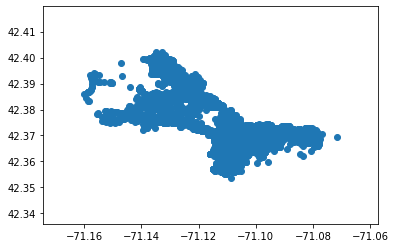

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.scatter(tickets['lon'],tickets['lat'])

The figure above shows a dot for each location that received a ticket in between 2007 and 2019. The tickets are distributed all over the city! 



The next stage is to tie these locations to an address and an identifier in the BldgID2WeatherIdentifier.csv file. Here I'm using a trick to make the code tun a little faster: only searching within a certain radius.

In [36]:
identifierLocation = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/processed/BldgID2WeatherIdentifier.csv')

from geopy.distance import geodesic
def find_nearest_building(df,latI,lonI):
    minDist = 4000
    for i in range(0,df.shape[0]):
        lat = df['lat'].iloc[i]
        lon = df['lon'].iloc[i]
        dist = geodesic([lat,lon],[latI,lonI]).meters
        if dist<minDist:
            minDist = dist
            nearestBuildingInDf = i
    return nearestBuildingInDf

identifierLocation.keys()

Index(['Unnamed: 0', 'Building ID', 'lat', 'lon', 'identifier'], dtype='object')

In [38]:
# running over the tickets, cutting part of the identifierLocation DataaFrame close to each 
# ticket location, and finding the closest match building wise:

lat_radius=abs(tickets['lat'].min()-tickets['lat'].max())/25
lon_radius = abs(tickets['lon'].min()-tickets['lon'].max())/25

tickets_feature = pd.DataFrame()
for i in range(0,tickets.shape[0]):
    lat = tickets['lat'].iloc[i]
    lon = tickets['lon'].iloc[i]
    minLat = lat-lat_radius
    maxLat = lat+lat_radius
    minLon = lon-lon_radius
    maxLon = lon+lon_radius
    df = identifierLocation[identifierLocation['lat']<maxLat]
    df = df[df['lat']>minLat]
    df = df[df['lon']<maxLon]
    df = df[df['lon']>minLon]
    #print(df.shape[0])
    # df now contains all the buildings withing the given lat/lon circle around the ticket location.
    # one of these buildings is the one that received the ticket:
    nearestBuildingIloc = find_nearest_building(df,lat,lon)
    tmp = df.iloc[nearestBuildingIloc]
    tmp['date'] = tickets['OFFENSE DATE'].iloc[i]
    tickets_feature = pd.concat([tickets_feature,tmp])

0.0019419780399999808 0.0035393061999997146


/Users/nbechor/Insight/noslipwalk/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 